In [2]:
import sys
import time
import traceback
import os
from arduino_iot_cloud import ArduinoCloudClient
import csv 
import time
import plotly.io as pio
import plotly.express as px
import pandas as pd
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt

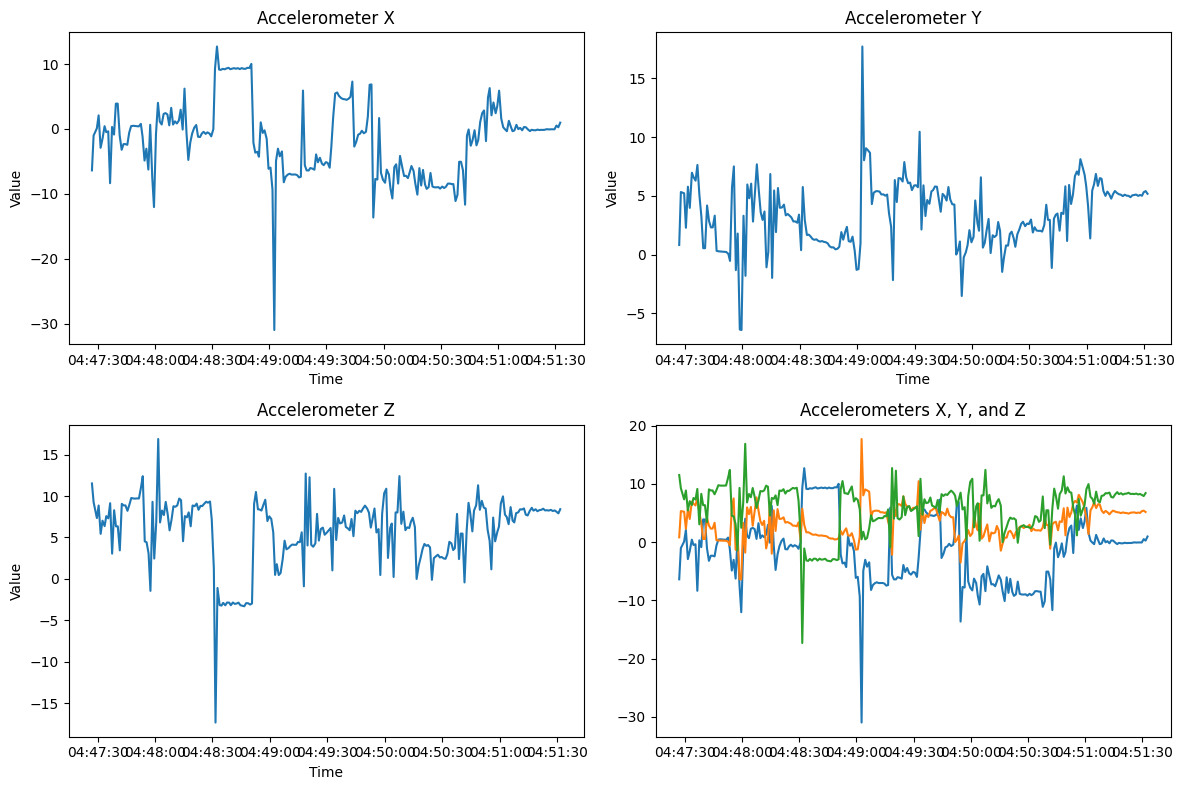

In [7]:

# Load the data
accelerometer_x = pd.read_csv('Accelerometer_X.csv')
accelerometer_y = pd.read_csv('Accelerometer_Y.csv')
accelerometer_z = pd.read_csv('Accelerometer_Z.csv')

accelerometer_x.time = pd.to_datetime(accelerometer_x.time)
accelerometer_y.time = pd.to_datetime(accelerometer_y.time)
accelerometer_z.time = pd.to_datetime(accelerometer_z.time)

# Plotting accelerometer_x
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(accelerometer_x['time'], accelerometer_x['value'])
plt.title('Accelerometer X')

# Plotting accelerometer_y
plt.subplot(2, 2, 2)
plt.plot(accelerometer_y['time'], accelerometer_y['value'])
plt.title('Accelerometer Y')

# Plotting accelerometer_z
plt.subplot(2, 2, 3)
plt.plot(accelerometer_z['time'], accelerometer_z['value'])
plt.title('Accelerometer Z')

# Plotting all three accelerometers
plt.subplot(2, 2, 4)
plt.plot(accelerometer_x['time'], accelerometer_x['value'], label='X')
plt.plot(accelerometer_y['time'], accelerometer_y['value'], label='Y')
plt.plot(accelerometer_z['time'], accelerometer_z['value'], label='Z')
plt.title('Accelerometers X, Y, and Z')


for i in range(3):
    plt.subplot(2,2,i+1)
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [8]:
### Receiving the data from Python

In [4]:

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='live-update-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0)  # Update every second  
])

@app.callback(
    Output('live-update-graph', 'figure'),
    Input('interval-component', 'n_intervals')
)

def update_graph(n_intervals):
    global cur_data
    # Convert to DataFrame for Plotly
    df = pd.DataFrame(cur_data, columns=['index','Timestamp', 'X', 'Y', 'Z'])
    fig = px.line(df, x= 'Timestamp', y = ['X','Y','Z'])  # Scatter plot

    return fig

In [1]:
import sys
import time
import traceback
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from arduino_iot_cloud import ArduinoCloudClient
from datetime import datetime

# Arduino Cloud Credentials
DEVICE_ID = "ad8f6b60-e433-4fae-8837-353a60d7fd24"
SECRET_KEY = "wOVhEZaSAUO39o2GWI6?qZ@n9"

# Data holders
temp_data = []
x, y, z = 0, 0, 0
count = 0
N_SAMPLES = 20  # Change to 1000+ for real use

# Callback functions
def on_accelerometer_x_changed(client, value):
    global x
    x = value

def on_accelerometer_y_changed(client, value):
    global y
    y = value

def on_accelerometer_z_changed(client, value):
    global z
    z = value

# Main block
if __name__ == "__main__":
    try:
        os.makedirs("images", exist_ok=True)

        # Connect to Arduino IoT Cloud
        client = ArduinoCloudClient(
            device_id=DEVICE_ID,
            username=DEVICE_ID,
            password=SECRET_KEY,
            sync_mode=True
        )

        # Register variables
        client.register("py_X", value=None, on_write=on_accelerometer_x_changed)
        client.register("py_Y", value=None, on_write=on_accelerometer_y_changed)
        client.register("py_Z", value=None, on_write=on_accelerometer_z_changed)

        client.start()

        while True:
            if x is not None and y is not None and z is not None:
                if count < N_SAMPLES:
                    count += 1
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                    temp_data.append([count, timestamp, x, y, z])
                    print([count, timestamp, x, y, z])
                    x, y, z = None, None, None
                else:
                    # Save and exit after 1 batch
                    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                    df = pd.DataFrame(temp_data, columns=['Index', 'Timestamp', 'X', 'Y', 'Z'])

                    # Save CSV
                    df.to_csv(f"csv_{timestamp}.csv", index=False)

                    # Save HTML (interactive Plotly)
                    fig = px.line(df, x='Timestamp', y=['X', 'Y', 'Z'], title='Accelerometer Data')
                    fig.write_html(f"images/plot_{timestamp}.html")

                    # Save PNG (matplotlib)
                    plt.figure(figsize=(10, 5))
                    plt.plot(df['Timestamp'], df['X'], label='X')
                    plt.plot(df['Timestamp'], df['Y'], label='Y')
                    plt.plot(df['Timestamp'], df['Z'], label='Z')
                    plt.xticks(rotation=45)
                    plt.legend()
                    plt.title('Accelerometer Data (Matplotlib)')
                    plt.xlabel('Timestamp')
                    plt.ylabel('Acceleration')
                    plt.tight_layout()
                    plt.savefig(f"images/plot_{timestamp}.png")
                    plt.close()

                    print(f"✅ Data saved successfully to CSV and graphs at timestamp {timestamp}")
                    break  # Exit the loop

            client.update()

    except Exception as e:
        print("An error occurred:", e)
        traceback.print_exc()


[1, '2025-04-21 19:59:13', 0, 0, 0]
[2, '2025-04-21 19:59:13', -3.0142998695373535, 1.1827356815338135, 9.045293807983398]
[3, '2025-04-21 19:59:14', -2.58813214302063, 1.2449848651885986, 9.387664794921875]
[4, '2025-04-21 19:59:15', -1.86508309841156, 1.0319008827209473, 9.246406555175781]
[5, '2025-04-21 19:59:17', 15.107412338256836, -3.7876269817352295, 8.068459510803223]
[6, '2025-04-21 19:59:18', 25.127147674560547, 0.7781155705451965, 17.209522247314453]
[7, '2025-04-21 19:59:19', 13.414711952209473, 1.0247182846069336, -9.914389610290527]
[8, '2025-04-21 19:59:20', -8.188169479370117, 3.1052796840667725, -0.6153098344802856]
[9, '2025-04-21 19:59:21', -1.8626888990402222, 4.527435302734375, 9.337387084960938]
[10, '2025-04-21 19:59:22', 5.652710437774658, 2.4851813316345215, 8.40843677520752]
[11, '2025-04-21 19:59:23', 4.946420669555664, 6.205770969390869, 10.558429718017578]
[12, '2025-04-21 19:59:25', 6.84981107711792, 4.244919776916504, 6.3733649253845215]
[13, '2025-04-21

In [ ]:
app.run_server(debug_mode = True, jupyter_tab = True)

[2025-04-22 01:18:31,045] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "c:\Users\tilla\AppData\Local\Programs\Python\Python313\Lib\site-p

In [20]:
import pandas as pd
_df = pd.read_csv("walking.csv")
_df.drop(columns=[col for col in ["Unnamed: 0", "index"] if col in _df.columns], inplace=True)
_df.Timestamp = pd.to_datetime(_df.Timestamp)
_df.set_index("Timestamp", inplace=True)
print(_df.head())


                     Index          X         Y         Z
Timestamp                                                
2025-04-21 19:59:13      1   0.000000  0.000000  0.000000
2025-04-21 19:59:13      2  -3.014300  1.182736  9.045294
2025-04-21 19:59:14      3  -2.588132  1.244985  9.387665
2025-04-21 19:59:15      4  -1.865083  1.031901  9.246407
2025-04-21 19:59:17      5  15.107412 -3.787627  8.068460


In [11]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("walking.csv")  # Replace with your actual filename

# Step 2: Convert 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Set 'Timestamp' as the index
df.set_index('Timestamp', inplace=True)

# Step 4: Filter by time using between_time
act_1 = df.between_time("19:59:13", "19:59:15")
act_2 = df.between_time("19:59:16", "19:59:17")
act_3 = df.between_time("19:59:18", "19:59:20")
act_4 = df.between_time("19:59:21", "19:59:25")
act_5 = df.between_time("19:59:30", "19:59:33")



In [12]:
act_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2025-04-21 19:59:13 to 2025-04-21 19:59:15
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   4 non-null      int64  
 1   X       4 non-null      float64
 2   Y       4 non-null      float64
 3   Z       4 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 160.0 bytes


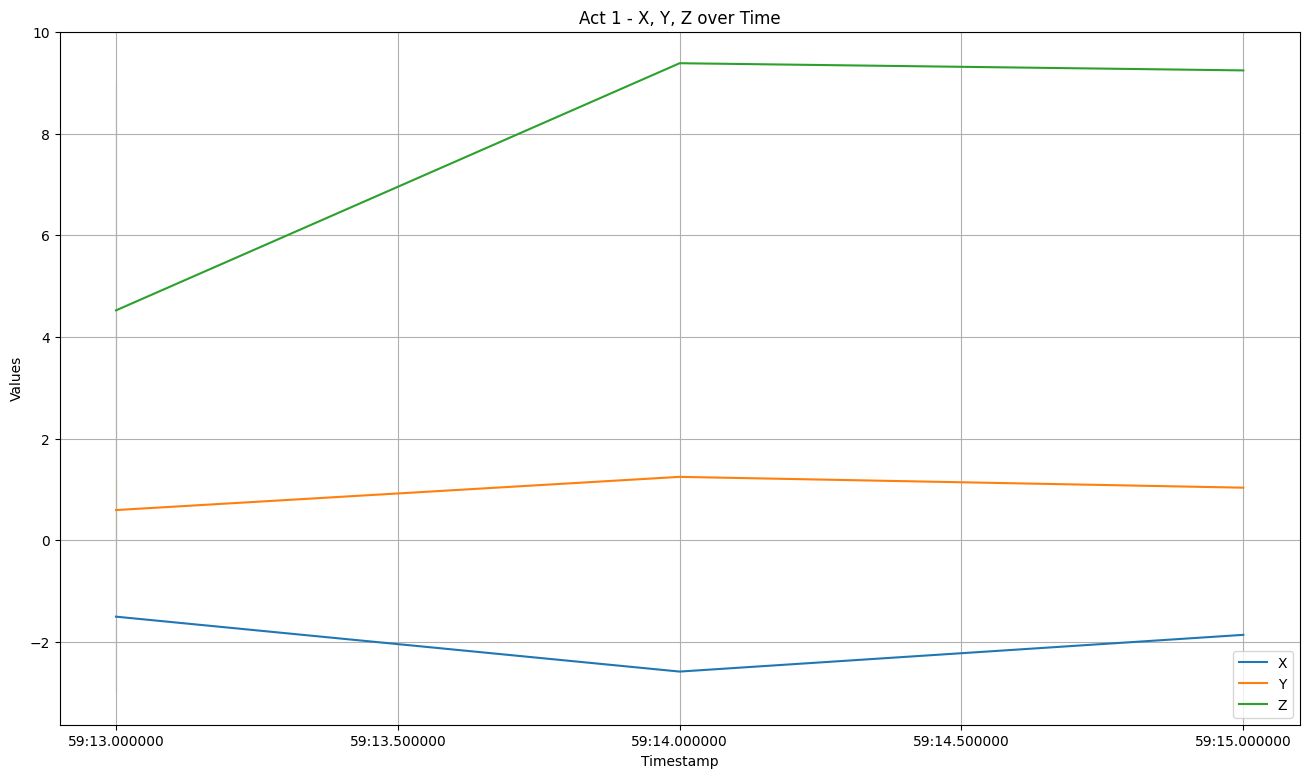

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

sns.lineplot(x=act_1.index, y=act_1["X"], label="X")
sns.lineplot(x=act_1.index, y=act_1["Y"], label="Y")
sns.lineplot(x=act_1.index, y=act_1["Z"], label="Z")

plt.title("Act 1 - X, Y, Z over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()


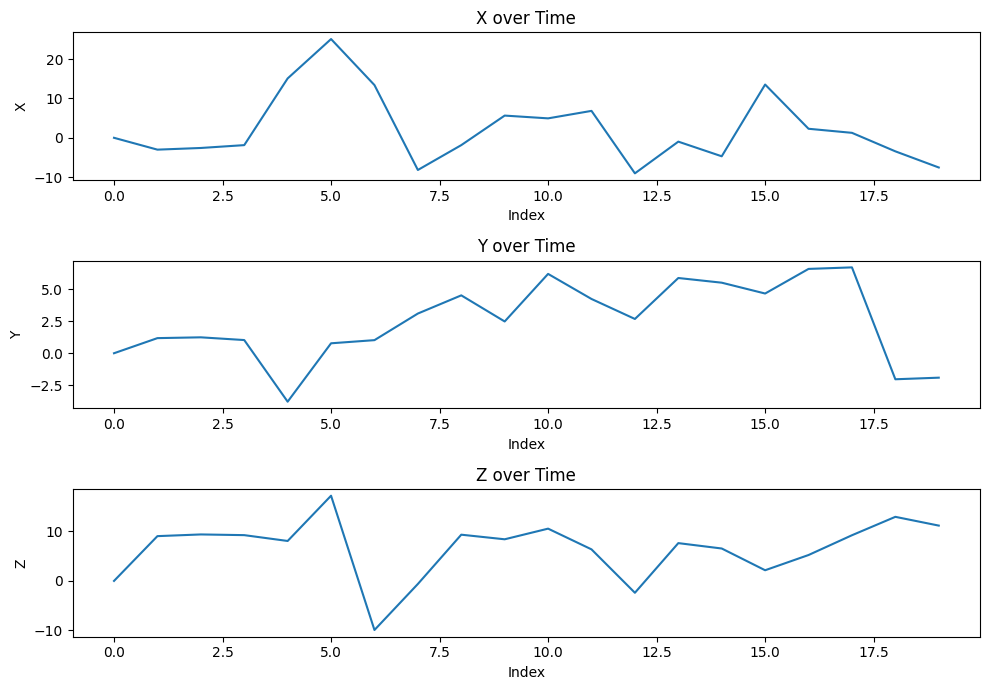

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (change filename if needed)
ydata = pd.read_csv("walking.csv")  # Replace with actual file path if needed

# Optional: Set the Timestamp as index if you want time on x-axis
# ydata['Timestamp'] = pd.to_datetime(ydata['Timestamp'])
# ydata.set_index('Timestamp', inplace=True)

# Use the DataFrame's index or Timestamp for the x-axis
x_axis = ydata.index  # or ydata['Timestamp'] if datetime index used

fig, axs = plt.subplots(3, figsize=(10, 7))  # 3 plots for X, Y, Z

columns_to_plot = ['X', 'Y', 'Z']

for i, col in enumerate(columns_to_plot):
    if col in ydata.columns:
        sns.lineplot(x=x_axis, y=ydata[col], ax=axs[i])
        axs[i].set_title(f'{col} over Time')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel(col)
    else:
        axs[i].text(0.5, 0.5, f'Missing column: {col}', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=axs[i].transAxes)
        axs[i].set_title('Data Missing')
        axs[i].set_xticks([])
        axs[i].set_yticks([])

plt.tight_layout()
plt.show()


In [16]:
# Step 1: Check if act_1 and act_2 have any rows
print(len(act_1), len(act_2))

# Step 2: Peek into them
print(act_1.head())
print(act_2.head())

# Step 3: See the columns
print(act_1.columns)



4 1
                     Index         X         Y         Z
Timestamp                                               
2025-04-21 19:59:13      1  0.000000  0.000000  0.000000
2025-04-21 19:59:13      2 -3.014300  1.182736  9.045294
2025-04-21 19:59:14      3 -2.588132  1.244985  9.387665
2025-04-21 19:59:15      4 -1.865083  1.031901  9.246407
                     Index          X         Y        Z
Timestamp                                               
2025-04-21 19:59:17      5  15.107412 -3.787627  8.06846
Index(['Index', 'X', 'Y', 'Z'], dtype='object')


In [18]:
act_2.describe()


,Index,X,Y,Z
count,1.0,1.000000,1.000000,1.00000
mean,5.0,15.107412,-3.787627,8.06846
std,NaN,NaN,NaN,NaN
min,5.0,15.107412,-3.787627,8.06846
25%,5.0,15.107412,-3.787627,8.06846
50%,5.0,15.107412,-3.787627,8.06846
75%,5.0,15.107412,-3.787627,8.06846
max,5.0,15.107412,-3.787627,8.06846
